## Шаг 1 - Создать Jypyter Notebook и подключить необходимые библиотеки.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import requests
import plotly.express as px
from dotenv import load_dotenv

## Шаг 2 - Изучить данные.

<h4>Запросить данные по посещениям по API за период 2023-03-01 -> 2023-09-0</h4>

In [5]:
url_visit = 'https://data-charts-api.hexlet.app/visits'
params = {
    'begin': '2023-03-01',
    'end': '2023-09-01'
}

# Чтение данных
resp1 = requests.get(url_visit, params=params)
visit = pd.DataFrame(resp1.json())

# Приводим дату к нужному формату
visit = visit.sort_values(by='datetime')
visit['datetime'] = pd.to_datetime(visit['datetime'])
visit['datetime'] = visit['datetime'].dt.strftime('%Y-%m-%d')
visit = visit.rename(columns={'datetime': 'date'})

visit.head()

,visit_id,platform,user_agent,date
1845,25c1dcbb-cb2d-41dc-88c0-8f5dd8d18483,web,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:109...,2023-03-01
1560,b09b2b11-0d64-46a2-954a-d8bcd54b207f,web,Mozilla/5.0 (X11; CrOS x86_64 8172.45.0) Apple...,2023-03-01
272,348148db-9841-4b42-a0e1-7631f4667f83,web,Mozilla/5.0 (X11; CrOS x86_64 8172.45.0) Apple...,2023-03-01
81,65f98235-9667-460c-964e-5604b75b48a1,web,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,2023-03-01
607,9b298132-4992-4dff-9d5b-b8741d3b7870,web,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:15....,2023-03-01


<h4>Запросить данные по регистрации по API за период 2023-03-01 -> 2023-09-0</h4> 

In [7]:
url_reg = 'https://data-charts-api.hexlet.app/registrations'

# Чтение данных
resp2 = requests.get(url_reg, params=params)
reg = pd.DataFrame(resp2.json())

# Приводим дату к нужному формату
reg = reg.sort_values(by='datetime')
reg['datetime'] = pd.to_datetime(reg['datetime'])
reg['datetime'] = reg['datetime'].dt.strftime('%Y-%m-%d')
reg = reg.rename(columns={'datetime': 'date'})

reg.head()

,date,user_id,email,platform,registration_type
3,2023-03-01,3e9914e1-5d73-4c23-b25d-b59a3aeb2b60,halldavid@example.org,web,email
28,2023-03-01,b7ec78b7-fdf6-443c-bba6-01e719c26efe,smithrachel@example.net,android,google
22,2023-03-01,2aeb1afe-7641-416f-a21b-d747dbe8d754,kendra89@example.com,android,google
20,2023-03-01,7188b134-a628-4138-9d46-545fb99a91a7,ghernandez@example.net,android,email
55,2023-03-01,93ae2189-9f3c-47ea-ba0a-b06db9fb43ae,lisa22@example.net,android,google


#### Краткая сводка по данным visit и registrations

In [9]:
visit.describe()

,visit_id,platform,user_agent,date
count,263459,263459,263459,263459
unique,146085,4,32,184
top,7c00c346-a2ae-4dba-8fc8-92bd77afff44,web,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:109...,2023-03-08
freq,4,236301,13623,2624


In [10]:
reg.describe()

,date,user_id,email,platform,registration_type
count,21836,21836,21836,21836,21836
unique,184,21836,20868,3,4
top,2023-03-06,3e9914e1-5d73-4c23-b25d-b59a3aeb2b60,ujones@example.com,android,email
freq,230,1,6,10582,8996


## Шаг 3 - Расчет метрик.

In [41]:
# Фильтруем визиты ботов
visit_filtered = visit[~visit['user_agent'].str.contains('bot')]

# Находим последнее посещение каждого пользователя
last_visit = (visit_filtered
              .sort_values(['visit_id', 'date'])
              .drop_duplicates(subset=['visit_id'], keep='last'))

# Группировка посещений по дате и платформе посещения 
visit_group = (last_visit
               .groupby(['date', 'platform'])
               .size()
               .reset_index(name='visits')
               .rename(columns={'date': 'date_group'}))

# Группировка регистраций по дате и платформе
reg_group = (reg
             .groupby(['date', 'platform'])
             .agg(registrations=('user_id', 'count'))
             .reset_index()
             .rename(columns={'date': 'date_group'}))

# Соединяем датафреймы visit и reg
conversion = pd.merge(visit_group, reg_group, how='outer', on=['date_group', 'platform']).fillna(0)

# Считаем конверсию
conversion['conversion'] = (conversion['registrations'] * 100.0 / conversion['visits']).replace(0, np.nan)

# Сохраняем датафрейм в формате JSON
conversion.to_json('./conversion.json')

conversion.head()

,date_group,platform,visits,registrations,conversion
0,2023-03-01,android,75,61,81.333333
1,2023-03-01,ios,22,18,81.818182
2,2023-03-01,web,279,8,2.867384
3,2023-03-02,android,67,59,88.059701
4,2023-03-02,ios,31,24,77.419355


## Шаг 4 - Добавляем рекламы.

In [57]:
# Приведение формата даты в ads_campaign
ads_campaign = pd.read_csv('../ads.csv')
ads_campaign['date'] = pd.to_datetime(ads_campaign['date']).dt.date

# Группировка и агрегация по дате
ads_cost = ads_campaign.groupby(['date', 'utm_campaign']).agg(cost=('cost', 'sum')).reset_index()
ads_cost.rename(columns={'date': 'date_group'}, inplace=True)

# Приведение даты в conversion
conversion['date_group'] = pd.to_datetime(conversion['date_group']).dt.date

# Объединение датафреймов
ads_merge = pd.merge(conversion.groupby('date_group').agg(
        visits=('visits', 'sum'),
        registrations=('registrations', 'sum')).reset_index(),
    ads_cost,
    how='left', 
    on='date_group')

# Заполнение пропусков
ads_merge['utm_campaign'] = ads_merge['utm_campaign'].fillna('none')
ads_merge['cost'] = ads_merge['cost'].fillna(0)

# Итоговый датафрейм
ads = ads_merge[['date_group', 'visits', 'registrations', 'cost', 'utm_campaign']]

ads.head()

,date_group,visits,registrations,cost,utm_campaign
0,2023-03-01,376,87,212.0,advanced_algorithms_series
1,2023-03-02,613,106,252.0,advanced_algorithms_series
2,2023-03-03,683,107,202.0,advanced_algorithms_series
3,2023-03-04,647,159,223.0,advanced_algorithms_series
4,2023-03-05,707,115,265.0,advanced_algorithms_series


## Шаг 5 - Визуализация.

#### Итоговые визиты

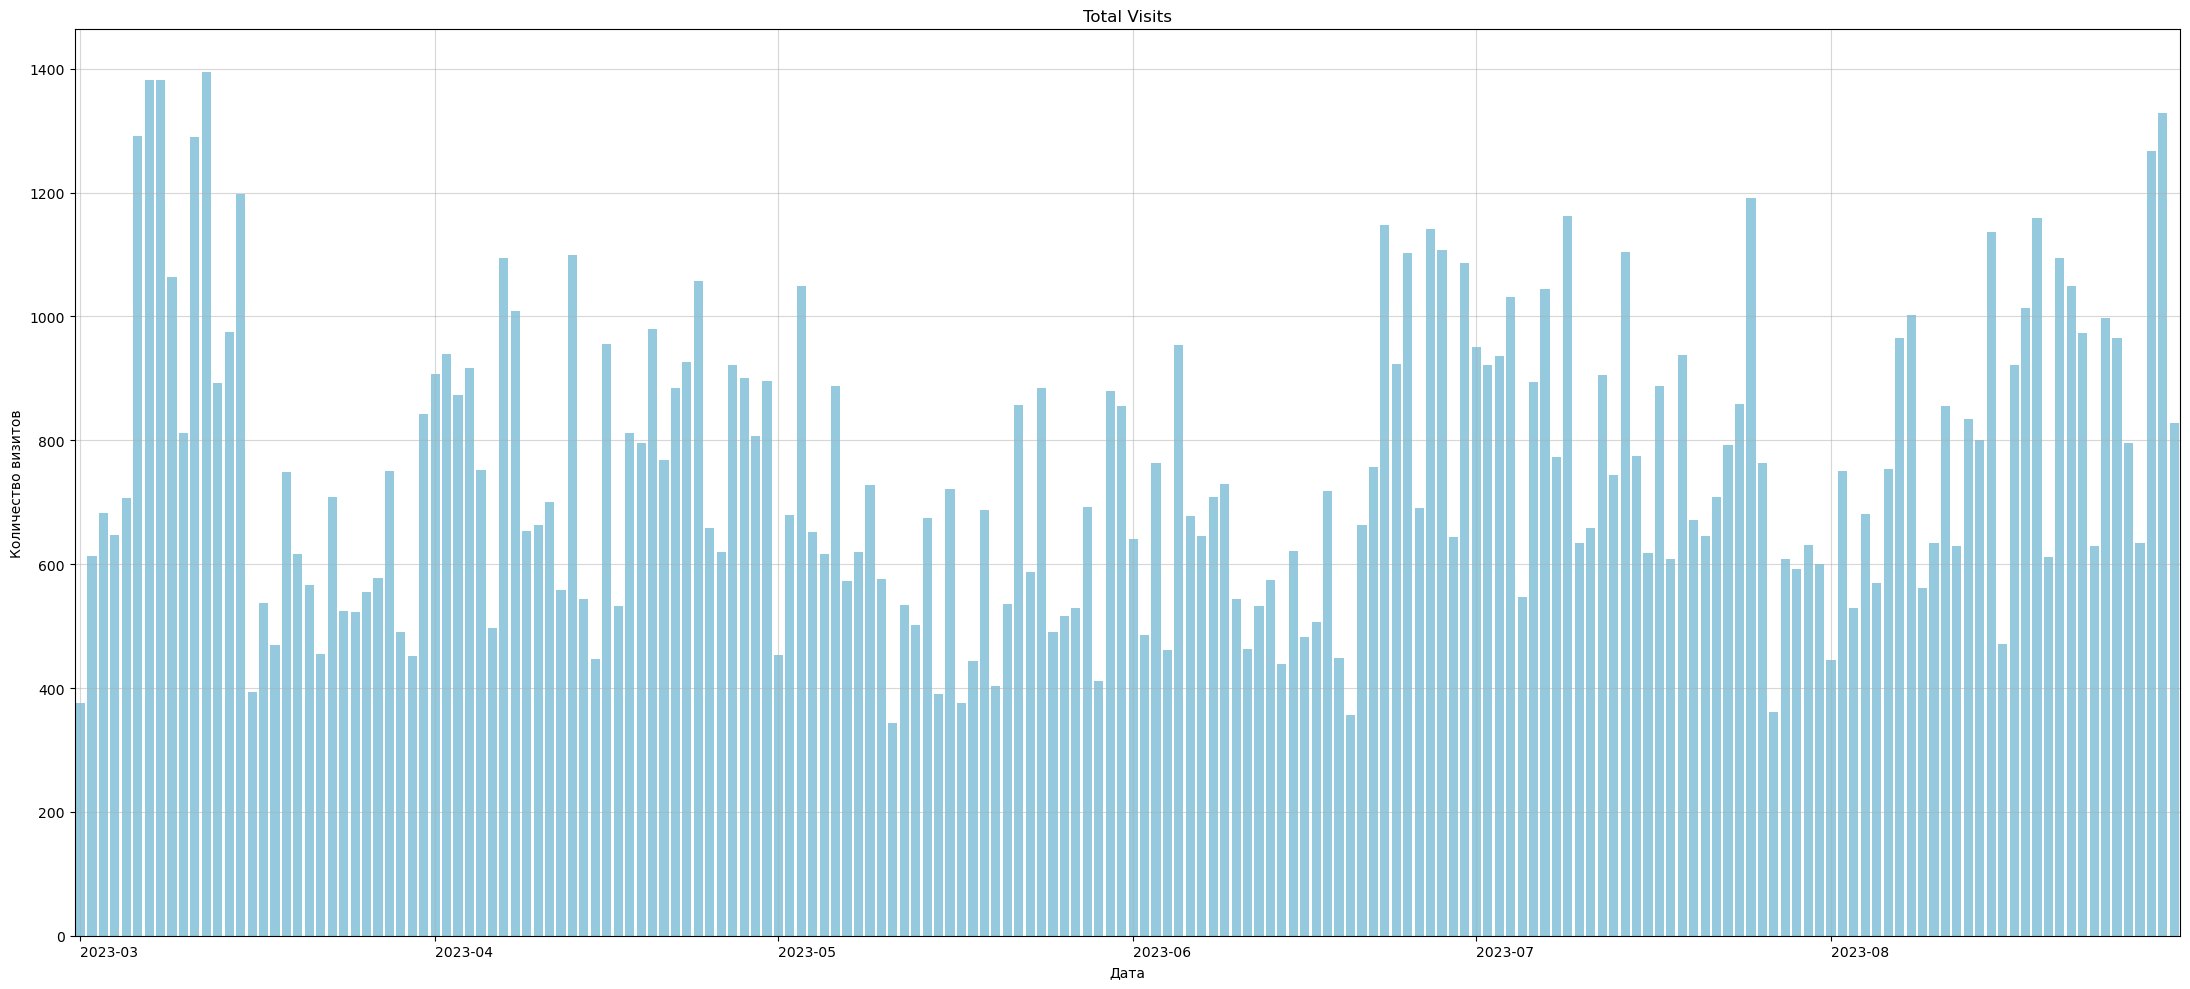

In [144]:
# Построение столбчатого графика
plt.figure(figsize=(22, 10))
sns.barplot(data=ads, x='date_group', y='visits', color='skyblue')

# Получение первых дней месяца
ads['date_group'] = pd.to_datetime(ads['date_group'])
monthly_ticks = ads[ads['date_group'].dt.is_month_start]

# Установка меток для оси X
plt.xticks(
    ticks=monthly_ticks.index,  # Индексы для меток
    labels=monthly_ticks['date_group'].dt.strftime('%Y-%m'),  # Форматированные подписи
    rotation=0,
    ha='left'
)

plt.xlabel('Дата')
plt.ylabel('Количество визитов')
plt.title('Total Visits')
plt.grid(alpha=0.5)
plt.tight_layout()

# Сохранение графика
plt.savefig('./charts/total_visits.png')
plt.show()

#### Итоговые визиты с разбивкой по платформам: web, android, ios

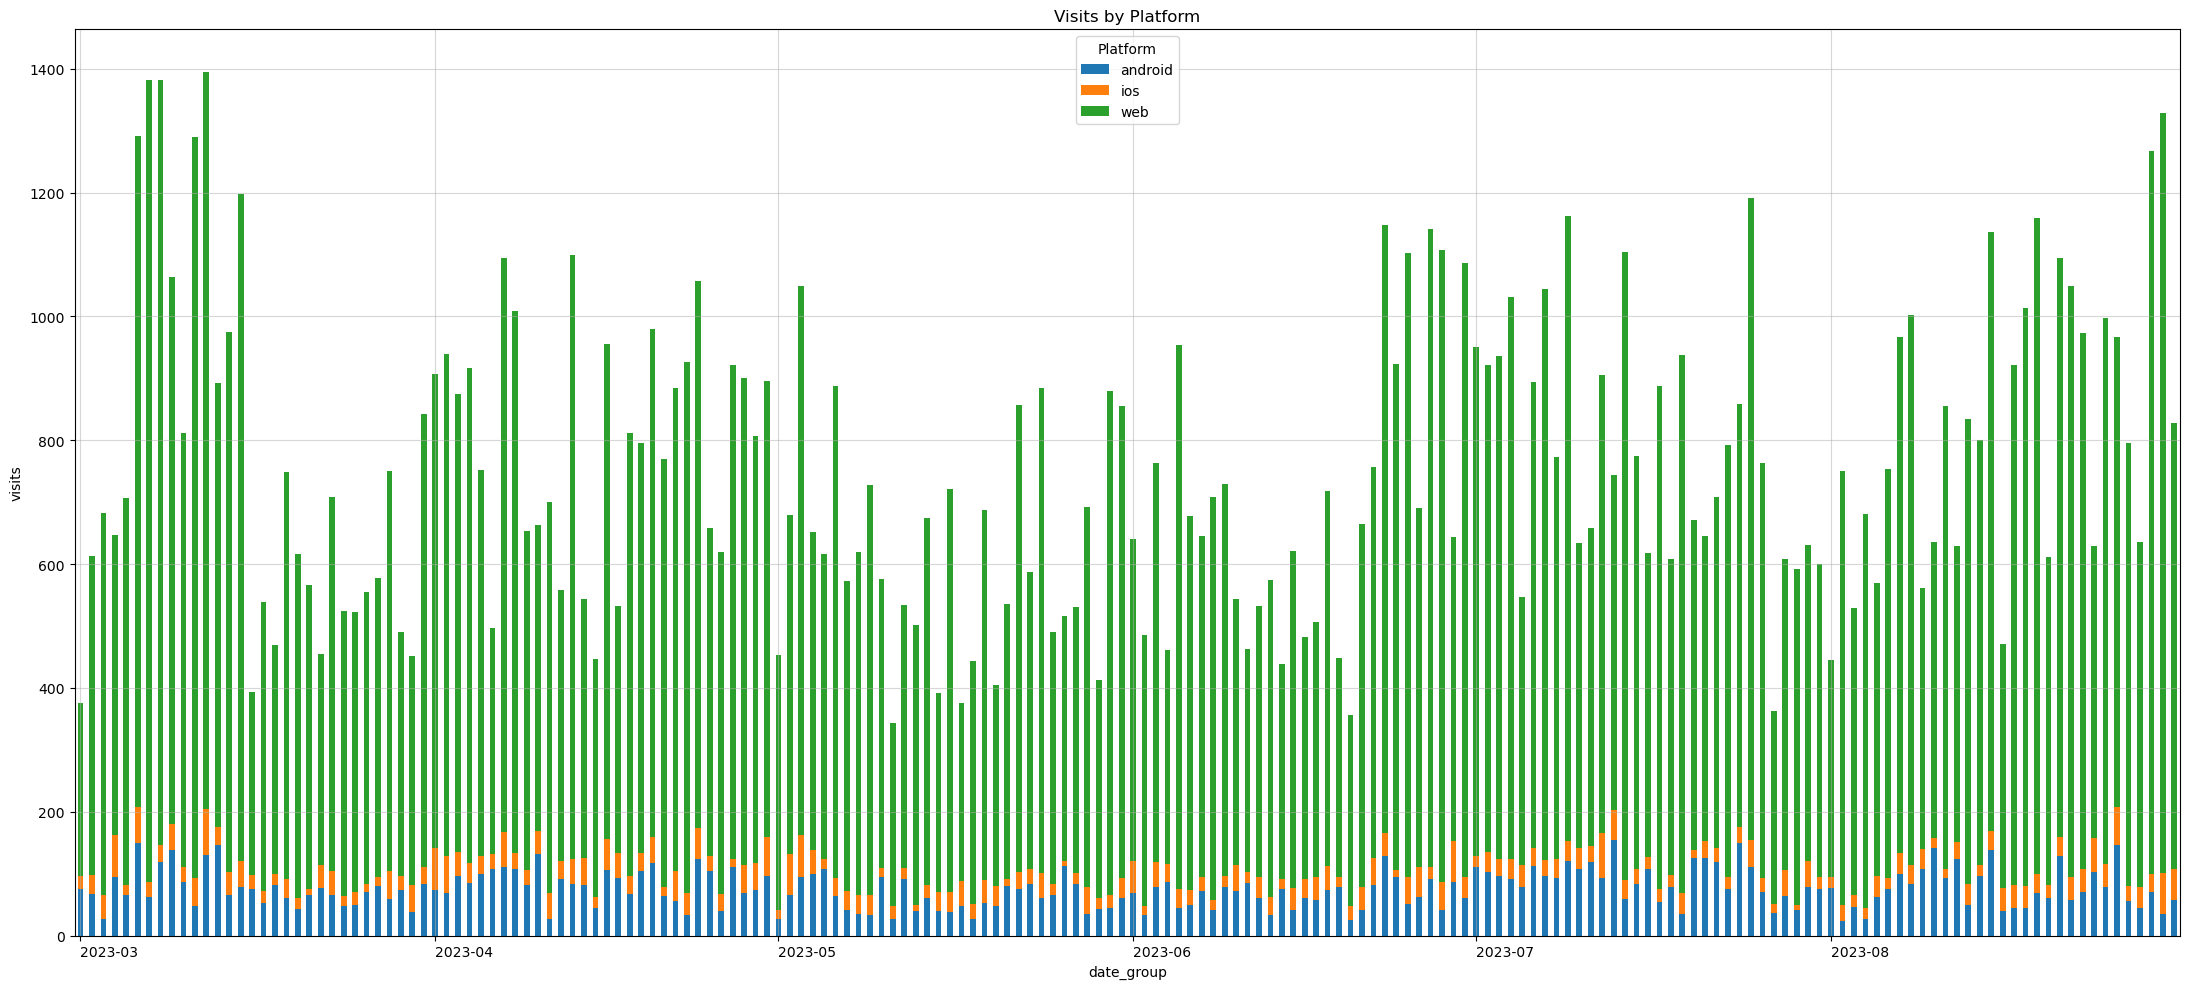

In [61]:
stacked_data_visits = conversion.pivot_table(index='date_group', columns='platform', values='visits', aggfunc='sum', fill_value=0)

plt.figure(figsize=(22, 10))
stacked_data_visits.plot(kind='bar', stacked=True, ax=plt.gca())

# Настройки графика
plt.xlabel('date_group')
plt.ylabel('visits')
plt.title('Visits by Platform')

# Преобразуем индекс в pd.DatetimeIndex и получаем только первые дни месяца
stacked_data_visits.index = pd.to_datetime(stacked_data_visits.index)
first_of_month_dates = stacked_data_visits.index[stacked_data_visits.index.day == 1]  # Получаем только первые дни месяца
first_of_month_dates_positions = [stacked_data_visits.index.get_loc(date) for date in first_of_month_dates]

# Настройка подписей на оси X
plt.xticks(first_of_month_dates_positions, labels=first_of_month_dates.strftime('%Y-%m'), rotation=0, ha='left')

# Сетка и легенда
plt.grid(alpha=0.5)
plt.legend(title='Platform')

# Обновление положения графика
plt.tight_layout()

# Сохранение и отображение графика
plt.savefig('./charts/visits_by_platform.png')

#### Итоговые регистрации

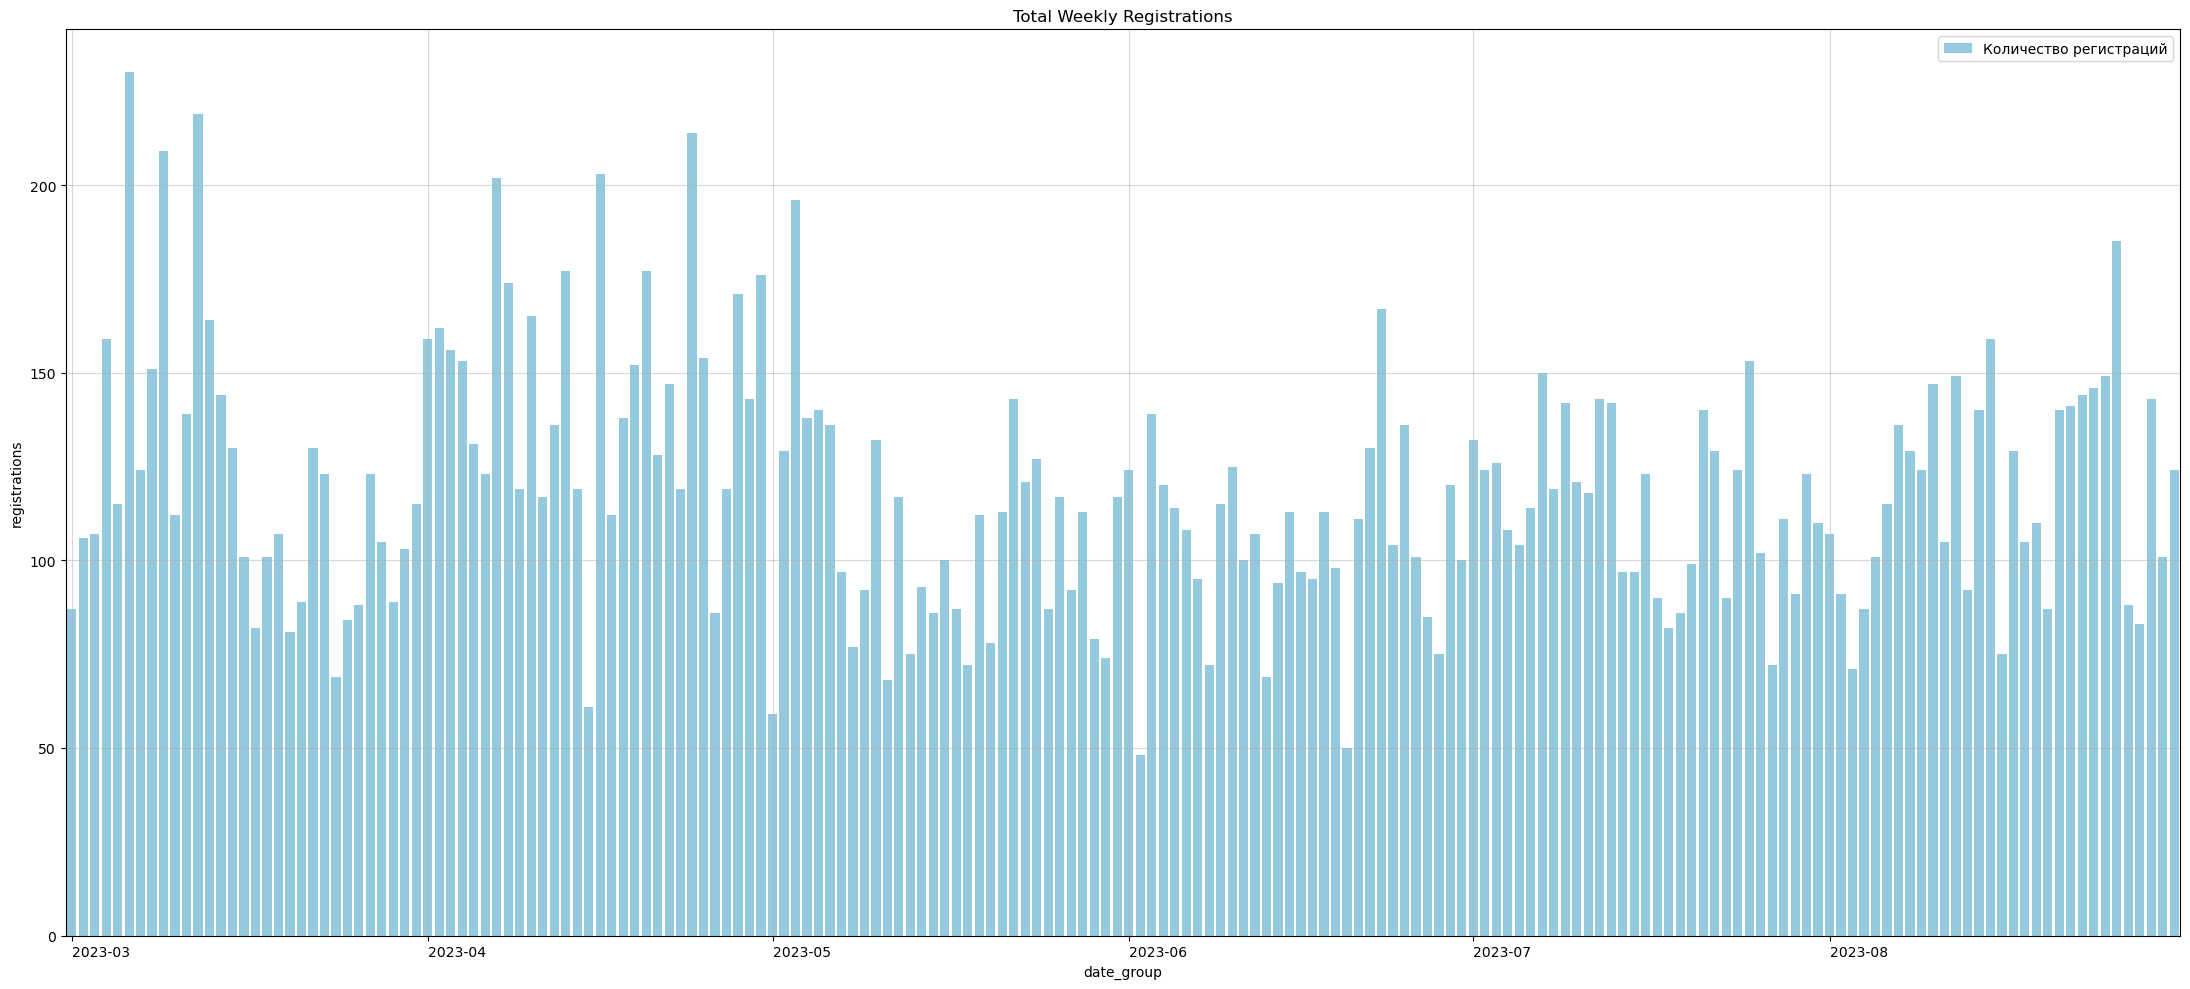

In [140]:
ads['date_group'] = pd.to_datetime(ads['date_group'])
monthly_ticks = ads[ads['date_group'].dt.is_month_start]

# Построение столбчатого графика
plt.figure(figsize=(22, 10))
sns.barplot(data=ads, x='date_group', y='registrations', color='skyblue', label='Количество регистраций')

# Настройки графика
plt.xlabel('date_group')
plt.ylabel('registrations')
plt.title('Total Weekly Registrations')

# Устанавливаем метки на оси X только для первых дней месяца
plt.xticks(monthly_ticks.index, labels=monthly_ticks['date_group'].dt.strftime('%Y-%m'), rotation=0, ha='left')
plt.grid(alpha=0.5)

# Легенда
plt.legend()

# Обновление положения графика
plt.tight_layout()

# Сохранение графика
plt.savefig('./charts/total_weekly_registrations.png')

# Отображение графика
plt.show()

#### Итоговые регистрации с разбивкой по платформе: web, android, ios

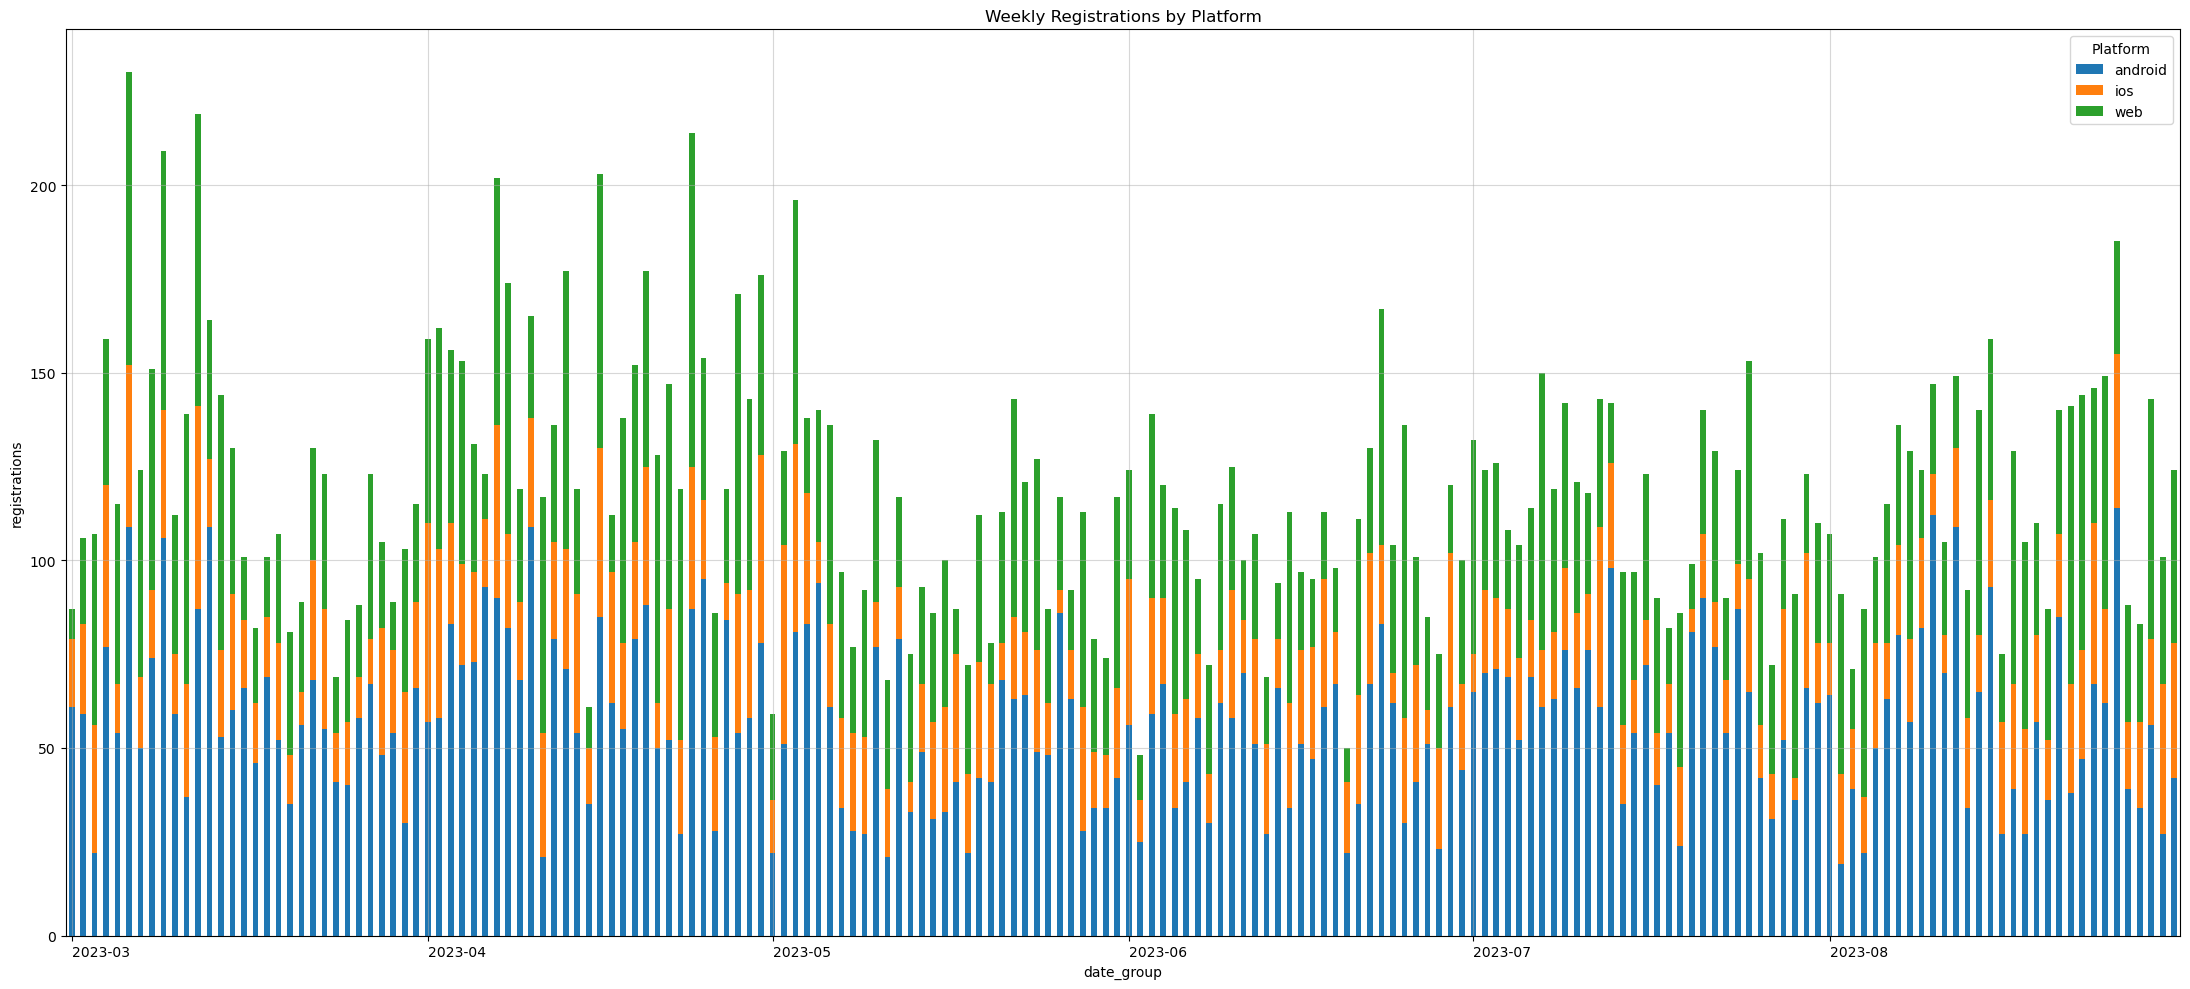

In [65]:
stacked_data_reg = conversion.pivot_table(index='date_group', columns='platform', values='registrations', aggfunc='sum', fill_value=0)

plt.figure(figsize=(22, 10))
stacked_data_reg.plot(kind='bar', stacked=True, ax=plt.gca())

# Настройки графика
plt.xlabel('date_group')
plt.ylabel('registrations')
plt.title('Weekly Registrations by Platform')

# Преобразуем индекс в pd.DatetimeIndex и получаем только первые дни месяца
stacked_data_reg.index = pd.to_datetime(stacked_data_reg.index) 
first_of_month_dates_reg = stacked_data_reg.index[stacked_data_reg.index.day == 1]  # Получаем только первые дни месяца
first_of_month_dates_positions_reg = [stacked_data_reg.index.get_loc(date) for date in first_of_month_dates_reg]

# Настройка подписей на оси X
plt.xticks(first_of_month_dates_positions_reg, labels=first_of_month_dates_reg.strftime('%Y-%m'), rotation=0, ha='left')

# Сетка и легенда
plt.grid(alpha=0.5)
plt.legend(title='Platform')

# Обновление положения графика
plt.tight_layout()

# Сохранение и отображение графика
plt.savefig('./charts/weekly_registrations_by_platform.png')

#### Конверсия средняя

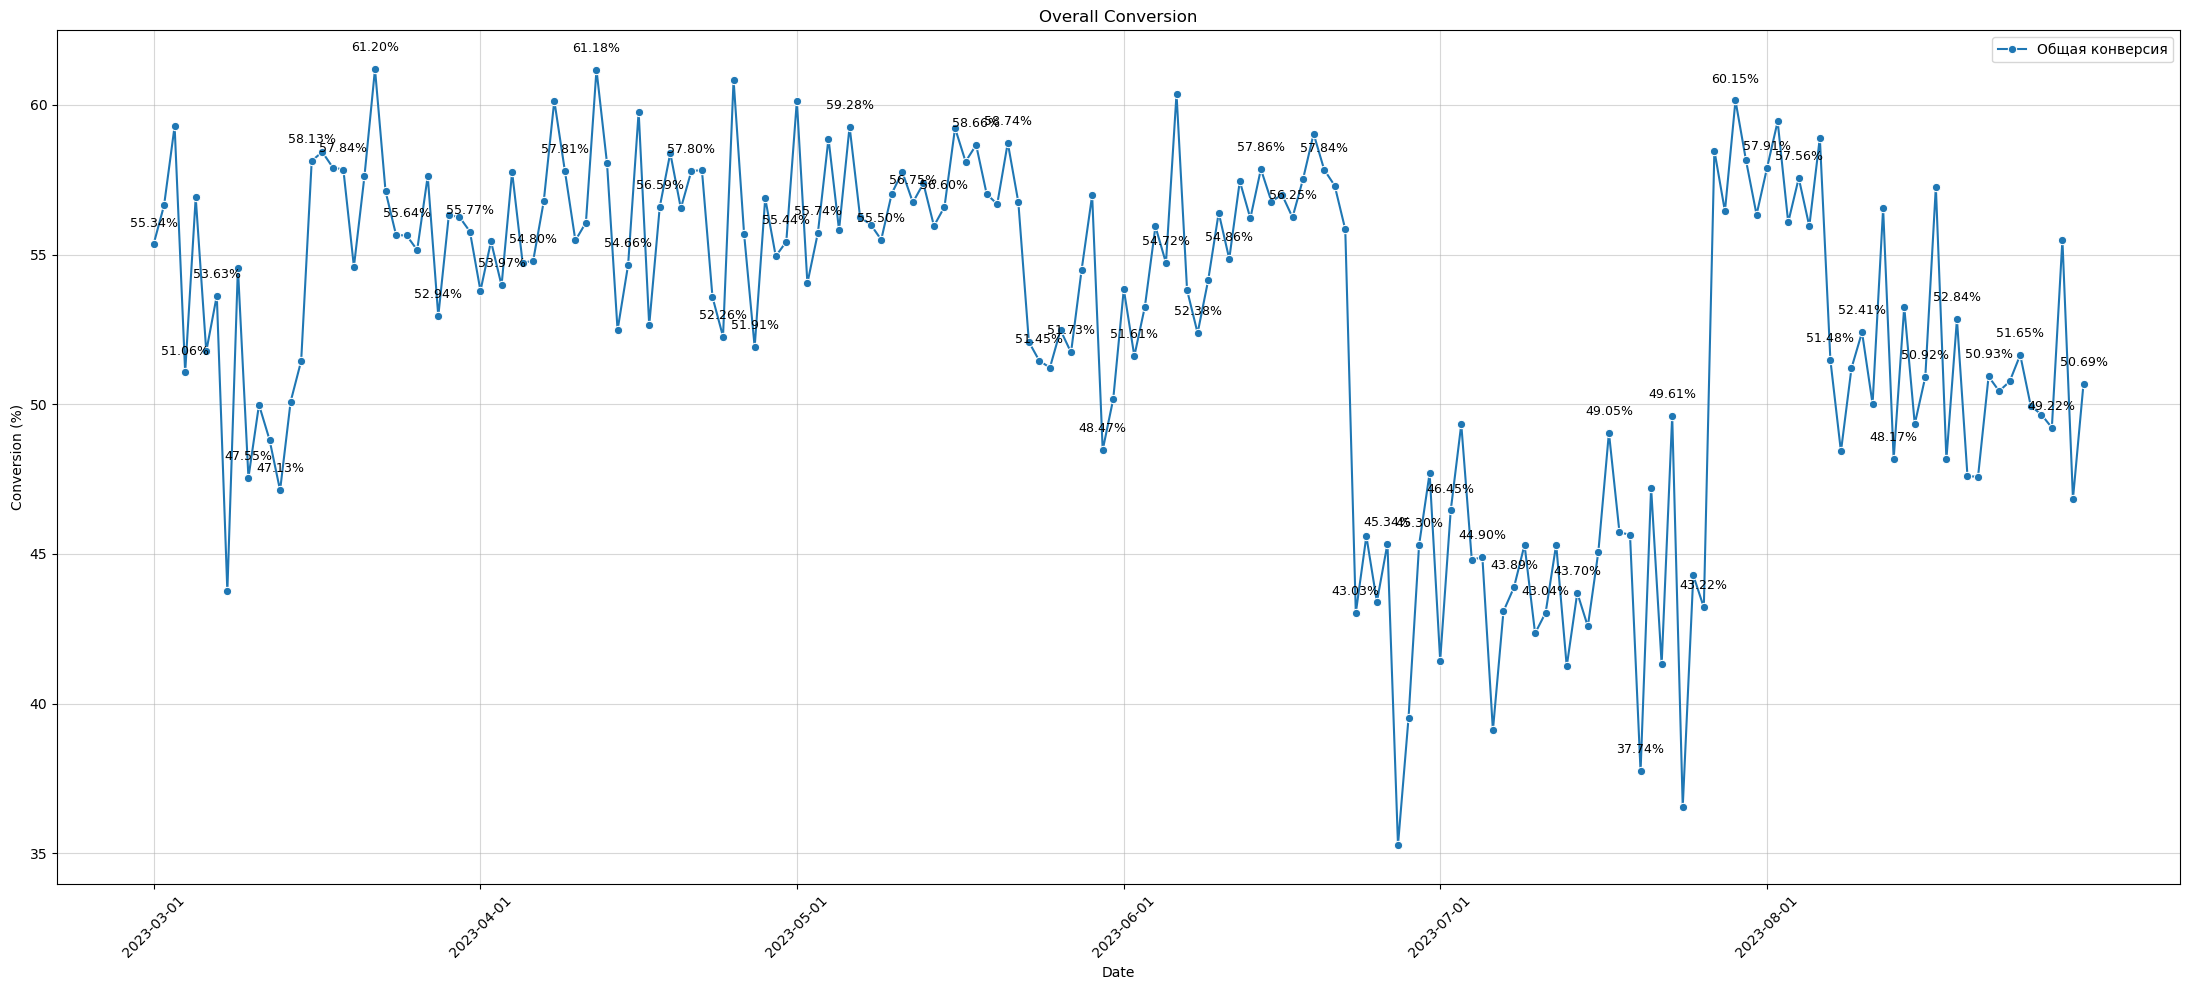

In [67]:
# Преобразуем даты в формат datetime
conversion['date_group'] = pd.to_datetime(conversion['date_group'])
conversion_mean = conversion.groupby('date_group', as_index=False).agg({'conversion': 'mean'})

plt.figure(figsize=(22, 10))
sns.lineplot(data=conversion_mean, x='date_group', y='conversion', marker='o', label='Общая конверсия')

month_ticks_con = conversion_mean['date_group'][conversion_mean['date_group'].dt.is_month_start]
plt.xticks(month_ticks_con, rotation=45)

for i in range(len(conversion_mean)):
    if i % 3 == 0:
        plt.text(
            x=conversion_mean['date_group'][i],
            y=conversion_mean['conversion'][i] + 0.5,  # Сместить текст чуть выше точки
            s=f"{conversion_mean['conversion'][i]:.2f}%",  # Формат с процентами
            fontsize=9,
            ha='center',
            va='bottom',
            color='black'
        )

plt.xlabel('Date')
plt.ylabel('Conversion (%)')
plt.title('Overall Conversion')
plt.grid(alpha=0.5)
plt.tight_layout()
plt.savefig('./charts/overall_conversion.png')

#### Конверсия по платформе

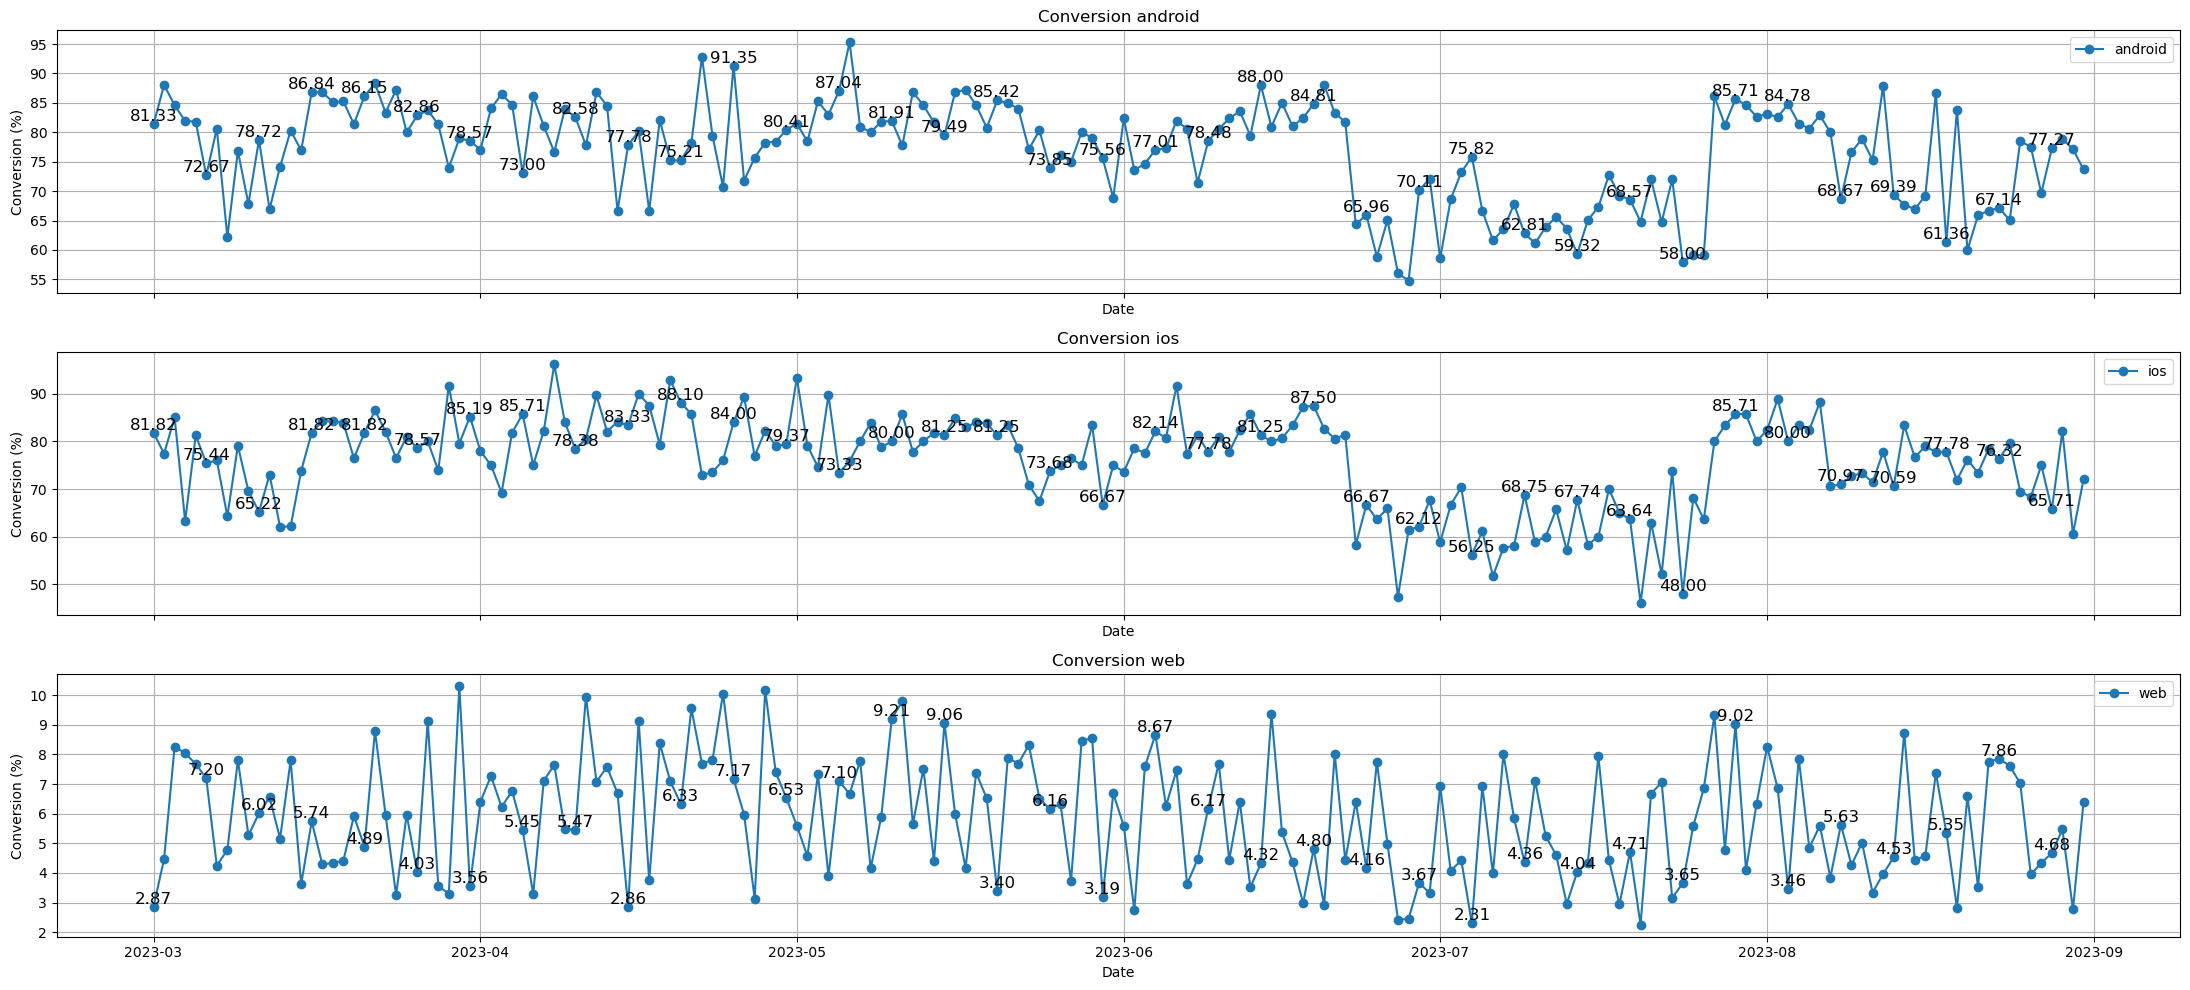

In [142]:
# Преобразуем даты в формат datetime
conversion['date_group'] = pd.to_datetime(conversion['date_group'])

# Уникальные платформы
platforms = conversion['platform'].unique()

# Создание фигуры с 3 подграфиками
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(22,10), sharex=True)

# Построение графиков
for i, platform in enumerate(platforms):
    platform_data = conversion[conversion['platform'] == platform]
    axes[i].plot(platform_data['date_group'], platform_data['conversion'], marker='o', label=f"{platform}")
    axes[i].set_title(f"Conversion {platform}")
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Conversion (%)')
    axes[i].legend()
    axes[i].grid()

    # Добавление значений
    for j, (x, y) in enumerate(zip(platform_data["date_group"], platform_data["conversion"])):
        if j % 5 == 0:
            axes[i].text(x, y, f"{y:.2f}", fontsize=12, ha="center", va="bottom")
for ax in axes:
    ax.tick_params(axis='x', rotation=0)

fig.tight_layout()
plt.savefig('./charts/conversion_by_platforms.png')

#### Стоимость рекламы

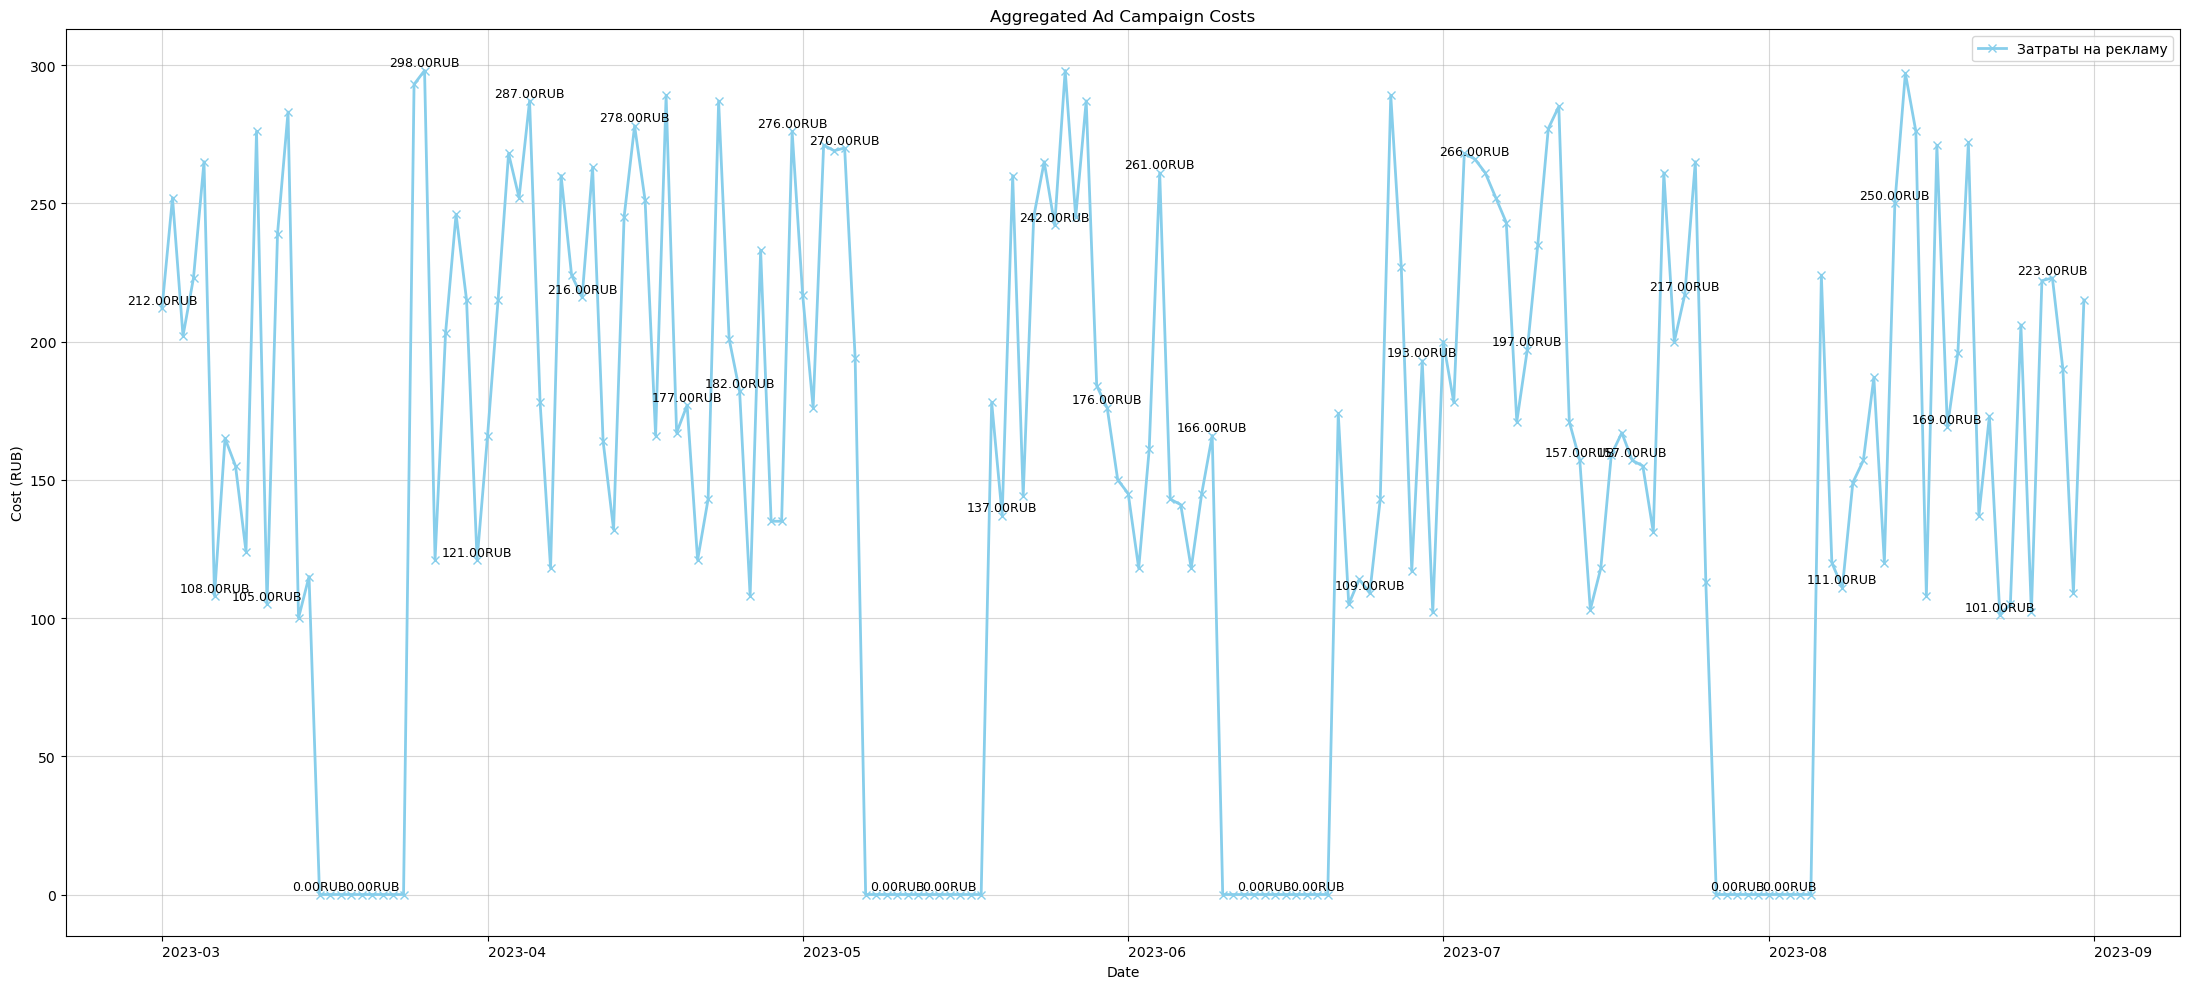

In [138]:
ads['date_group'] = pd.to_datetime(ads['date_group'])
monthly_ticks = ads[ads['date_group'].dt.is_month_start]

# Построение линейного графика
plt.figure(figsize=(22, 10))
plt.plot(ads['date_group'], ads['cost'], linestyle='-', linewidth=2, marker='x', color='skyblue', label='Затраты на рекламу')

for i in range(len(ads)):
    if i % 5 == 0:
        plt.text(
            x=ads['date_group'][i],
            y=ads['cost'][i] + 0.5,  # Сместить текст чуть выше точки
            s=f"{ads['cost'][i]:.2f}RUB",  # Формат с процентами
            fontsize=9,
            ha='center',
            va='bottom',
            color='black'
        )

plt.xlabel('Date')
plt.ylabel('Cost (RUB)')
plt.title('Aggregated Ad Campaign Costs')

plt.xticks(rotation=0, ha='left')
plt.grid(alpha=0.5)

plt.legend()
plt.tight_layout()

plt.savefig('./charts/aggregated_ad_campaign Costs.png')